In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import tensorflow as tf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import glob
uav_path = '../data/phantom/JUNE_01_PHANTOMS/wavs/*.wav'
none_path = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_0*.wav'
uav_files = glob.glob(uav_path)
none_files = glob.glob(none_path)

In [3]:
print(len(uav_files),'개\t', uav_files[0])
print(len(none_files), '개\t',none_files[0])

11 개	 ../data/phantom/JUNE_01_PHANTOMS/wavs\P1_stationary.wav
21 개	 ../data/phantom/JUNE_02_BACKGROUND/wavs/background\background_06_02_01.wav


# Load Data

The reason of why SR is 44100 is that the sample rate of above files is 44.1kbps

a wav file sample has 884736. if sample is divided by sample rate, the value is time
the time is fixed by 20.06

In [4]:
def loadSample(files,sample_rate):
    [sample_np, sample_rate] = librosa.load(files[0],sample_rate)
    print(len(sample_np), sample_rate, files[0])
    for f in files[1:]:
        [sample, sample_rate] = librosa.load(f,sample_rate)
        sample_np = np.hstack((sample_np, sample))
    return sample_np, sample_rate

In [5]:
SR = 44100
uav_sample, uav_sample_rate = loadSample(uav_files,SR )
none_sample, none_sample_rate = loadSample(none_files,SR)

print(uav_sample.shape,none_sample.shape )
combine = [[uav_sample,uav_path,uav_sample_rate],[none_sample,none_path,none_sample_rate]]

884736 44100 ../data/phantom/JUNE_01_PHANTOMS/wavs\P1_stationary.wav
884736 44100 ../data/phantom/JUNE_02_BACKGROUND/wavs/background\background_06_02_01.wav
(9732096,) (18579456,)


# Feature extraction 
## steps
#### 1. Resampling 
#### 2. *VAD*( Voice Activity Detection)
#### 3. Maybe padding with 0 to make signals be equal length
#### 4. Log spectrogram (or *MFCC*, or *PLP*)
#### 5. Features normalization with *mean* and *std*
#### 6. Stacking of a given number of frames to get temporal information



## 1. Resampling

if you see the graph, there are few at high frequency. this is mean that data is big but it's no useless. so To small the data, do Resampling. In general, use 0~8000Hz 

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
def showFreqTime(combine):
    for sample, filename, _ in combine:
        freqs, times, spectrogram = log_specgram(sample, SR)
        fig = plt.figure(figsize=(14, 10))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')
        ax1.plot(np.linspace(0, len(sample)/SR, len(sample)), sample)

        ax2 = fig.add_subplot(212)
        ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        ax2.set_title('Spectrogram of ' + filename)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')

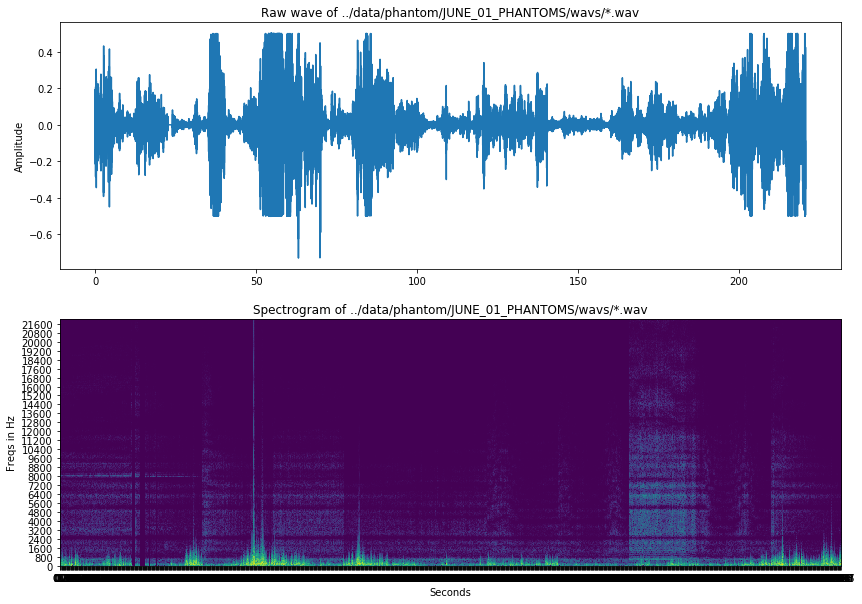

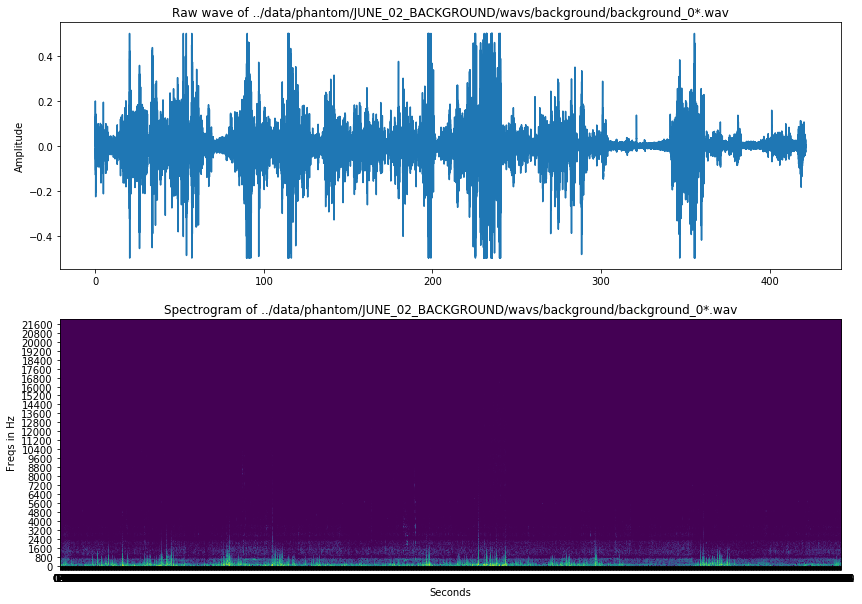

In [35]:
showFreqTime(combine)

In [9]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [10]:
new_sample_rate = combine[0][2]  #/4
combine_prev = combine[:]

combine = []
for samples, path, sample_rate in combine_prev:
    resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))
    combine.append([resampled,path,new_sample_rate])

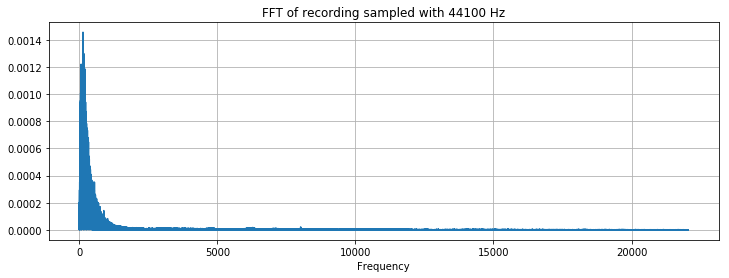

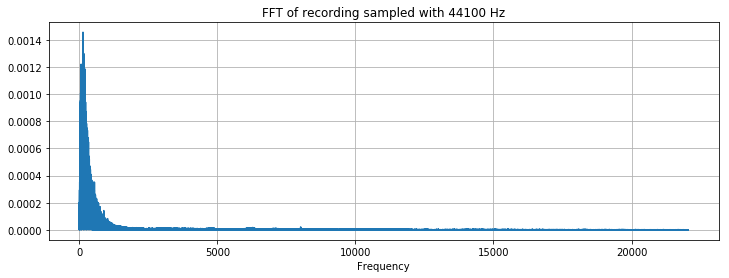

In [11]:
for samples, path, sample_rate in [combine_prev[0],combine[0]]:
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

### Data diffrence

qualiy is diffrence but, the data is almost same.

In [12]:
#ipd.Audio(combine_prev[0][0], rate=combine_prev[0][2])

In [13]:
#ipd.Audio(combine[0][0], rate=combine[0][2])

## 2. VAD

Sometimes, Files have silence. It is not necessary. So, We need to find sound of Drone except silence.

But, Not yet implemented

## 3. padding with 0 to make signals be equal length

If we have a lot of sound files, we need to pad some datas. But These files's time is longger than 1 second. So It dosn't need to pad

## 4. Log spectrogram (or MFCC, or PLP)

The upper picture is resampled data. 
The lower picture is original data.

In MFCC Feature, There is no big difference. 

In [14]:
from scipy.stats import skew
#returns mfcc features with mean and standard deviation along time
def get_mfcc(b):
    ft1 = librosa.feature.mfcc(b, sr = SR, n_mfcc=20)
    ft2 = librosa.feature.zero_crossing_rate(b)[0]
    ft3 = librosa.feature.spectral_rolloff(b)[0]
    ft4 = librosa.feature.spectral_centroid(b)[0]
    ft5 = librosa.feature.spectral_contrast(b)[0]
    ft6 = librosa.feature.spectral_bandwidth(b)[0]
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.min(ft1, axis = 1)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.min(ft6)))
    #print(len(ft1_trunc),len(ft2_trunc),len(ft3_trunc),len(ft4_trunc),len(ft5_trunc),len(ft6_trunc))
    return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
def mfcc(raw, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((13, 0))
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc = np.hstack((mfcc, mfcc_slice))
    return mfcc
def mfcc2(raw, label, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((0, n_mfcc, 17))
    y = []
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc_slice = mfcc_slice.reshape((1,n_mfcc,17))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y
def mfcc3(raw, label, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((n_mfcc*17, 0))
    y = []
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        #print(mfcc_slice)
        mfcc_slice = mfcc_slice.reshape((n_mfcc*17, 1)) #mfcc_slice.reshape((1,n_mfcc,17))
        #print(mfcc_slice)
        mfcc = np.hstaack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=44100, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [15]:
#use spectrogram
spectro_combine = []
for sample,path,sample_rate in combine:
    freqs, times, spectrogram = log_specgram(sample, sample_rate)
    spectro_combine.append([freqs, times, spectrogram ])
spectro_combine_tmp = spectro_combine

## 5. Features normalization with *mean* and *std*

In [18]:

spectrogram1 = spectro_combine[0][2]
spectrogram2 = spectro_combine[1][2]
spec = np.vstack((spectrogram1,spectrogram2))

mean = np.mean(spec, axis=0)
std = np.std(spec, axis=0)
spectro_combine[0][2] = (spectro_combine[0][2] - mean) / std
spectro_combine[1][2] = (spectro_combine[1][2] - mean) / std
#print(mean, std)
np.save('../data/Xy/RNN_mean', mean)
np.save('../data/Xy/RNN_std', std)

## 6. Stacking of a given number of frames to get temporal information

In [19]:
# or should we give one label to one chunk?
X_uav = spectro_combine[0][2]
X_none = spectro_combine[1][2]
#X_uav = mfcc_combine[0]
#X_none = mfcc_combine[1]
y_uav = np.ones(shape = [len(X_uav)], dtype=int)
y_none =np.zeros(shape =[len(X_none)], dtype=int)

combine_data = [[X_uav, y_uav],[X_none,y_none]]
print(y_uav.shape)
print(y_none.shape)

(22067,)
(42129,)


In [20]:
dataX = np.vstack((X_uav, X_none))
dataY = np.hstack((y_uav, y_none))
print(dataX.shape, dataY.shape)

(64196, 442) (64196,)


In [21]:
seq_length = 9 #layer
X_hot_list= []
#Y_hot = dataY[seq_length-1:].reshape(len(dataY[seq_length-1:]), 1)
Y_hot_tmp = dataY[seq_length-1:]

for i in range(0, dataX.shape[0] - seq_length+1):
    _x = dataX[i:i + seq_length]
    #if i<10:
        #print(_x, "->", Y_hot_tmp[i])
    X_hot_list.append(_x)

X_hot = np.array(X_hot_list[:])
Y_hot = Y_hot_tmp.reshape((len(Y_hot_tmp),1))
print(X_hot.shape, Y_hot.shape)


(64188, 9, 442) (64188, 1)


In [22]:
X_dim = 442
X_train = np.zeros(shape=[0,9,X_dim],dtype=float)
y_train = np.zeros(shape=[0,1],dtype=float)
X_test = np.zeros(shape=[0,9,X_dim],dtype=float)
y_test = np.zeros(shape=[0,1],dtype=float)

split_rate = 0.9
none_len = len(y_none)
uav_len = len(X_hot) - none_len
print('uav_len, none_len', uav_len,none_len)

train_size = int(uav_len * split_rate)
test_size = uav_len - train_size
base = 0
print('uav',train_size,test_size)

X_tr, X_te = np.array(X_hot[base:base+train_size]),np.array(X_hot[base+train_size:base+none_len])
y_tr, y_te = np.array(Y_hot[base:base+train_size]),np.array(Y_hot[base+train_size:base+none_len])
print(X_tr.shape,X_te.shape)
print(y_tr.shape,y_te.shape)

X_train = np.vstack((X_train,X_tr))
X_test= np.vstack((X_test,X_te))
y_train= np.vstack((y_train,y_tr))
y_test= np.vstack((y_test,y_te))

train_size = int(none_len * split_rate)
test_size = none_len - train_size
base = uav_len
print('none',train_size,test_size)

X_tr, X_te = np.array(X_hot[base:base+train_size]),np.array(X_hot[base+train_size:base+none_len])
y_tr, y_te = np.array(Y_hot[base:base+train_size]),np.array(Y_hot[base+train_size:base+none_len])
print(X_tr.shape,X_te.shape)
print(y_tr.shape,y_te.shape)

print(base+none_len)
X_train = np.vstack((X_train,X_tr))
X_test= np.vstack((X_test,X_te))
y_train= np.vstack((y_train,y_tr))
y_test= np.vstack((y_test,y_te))

uav_len, none_len 22059 42129
uav 19853 2206
(19853, 9, 442) (22276, 9, 442)
(19853, 1) (22276, 1)
none 37916 4213
(37916, 9, 442) (4213, 9, 442)
(37916, 1) (4213, 1)
64188


In [23]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(57769, 9, 442) (26489, 9, 442)
(57769, 1) (26489, 1)


In [24]:
'''
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)
'''

"\nnp.save('../data/Xy/X_train2', X_train)\nnp.save('../data/Xy/X_test2', X_test)\nnp.save('../data/Xy/y_train2', y_train)\nnp.save('../data/Xy/y_test2', y_test)\n"

In [25]:
'''
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')
'''

"\nX_train = np.load('../data/Xy/X_train2.npy')\nX_test = np.load('../data/Xy/X_test2.npy')\ny_train = np.load('../data/Xy/y_train2.npy')\ny_test = np.load('../data/Xy/y_test2.npy')\n"

# Tensorflow RNN

## Train 

In [26]:
learning_rate = 0.01

# train Parameters
#X_dim = 442 #n_dim #X_hot.shape[2]

#seq_length = #X_hot.shape[1]
output_dim = 1 #n_classes #Y_hot.shape[1]

hidden_dim = 2

In [27]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, X_dim], name = 'X')
Y = tf.placeholder(tf.float32, [None, output_dim], name = 'Y')

#X_one_hot = tf.one_hot(X, )
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
#cell = tf.contrib.rnn.MultiRNNCell([cell]*2, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_pred, labels = Y))

# optimizer
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(loss) #AdamOptimizer

# RMSE
targets = tf.placeholder(tf.float32, [None, output_dim] , name = 'targets')
predictions = tf.placeholder(tf.float32, [None, output_dim] , name = 'predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [28]:
X_train[0]

array([[ 1.5071255 ,  1.16292846,  0.22309478, ..., -0.23874724,
        -0.22733629, -0.24696735],
       [ 1.07184398,  0.91408926,  0.90895659, ..., -0.18009135,
        -0.2089148 , -0.21966761],
       [-2.40981627,  0.51195908,  1.36571836, ..., -0.18078455,
        -0.21465859, -0.25918874],
       ...,
       [-0.72709531,  0.47982168,  1.31215644, ...,  0.03224296,
        -0.17400368, -0.25839514],
       [ 1.43794644,  1.24117565,  1.15582514, ..., -0.0938672 ,
        -0.15032138, -0.24989232],
       [ 0.41018704,  1.2694248 ,  1.81657946, ..., -0.05716283,
        -0.21795307, -0.25565156]])

In [29]:
init = tf.global_variables_initializer()

cost_history = np.empty(shape=[1],dtype=float)
step_loss = 999999.0
model_path = '../models/RNN/my_RNN_model_S9_40'
saver = tf.train.Saver()
training_epochs = 10
# Training step

sess = tf.InteractiveSession()
sess.run(init)
for learning_rate in [0.02, 0.015, 0.01, 0.005]:
    test_acc = []
    feed = {lr:learning_rate, X: X_train, Y: y_train}
    for i in range(training_epochs):
        step_loss_prev = step_loss
        _, step_loss = sess.run([train, loss], feed_dict=feed)
        cost_history = np.append(cost_history,step_loss/X_train.shape[0])
        
        print("[step: {}] loss: {}".format(i, step_loss/X_train.shape[0]))
        #batch_acc, test_state = sess.run([loss, _states], feed_dict=feed)
    print("Test accuracy: {:.3f}".format(1.0-np.mean(cost_history)))

saver.save(sess, model_path)
sess.close()

[step: 0] loss: 0.4308963825754297
[step: 1] loss: 0.3965273803315792
[step: 2] loss: 0.28468275183273034
[step: 3] loss: 0.2504899463542298
[step: 4] loss: 0.22171740168818918
[step: 5] loss: 0.20633981758166145
[step: 6] loss: 0.18402311022672194
[step: 7] loss: 0.1568987820836002
[step: 8] loss: 0.14190885452729837
[step: 9] loss: 0.1337541713819263
Test accuracy: 0.804
[step: 0] loss: 0.13024072538634476
[step: 1] loss: 0.12789618256006682
[step: 2] loss: 0.125696360112582
[step: 3] loss: 0.12360839547919299
[step: 4] loss: 0.12160567234914055
[step: 5] loss: 0.11964324136052641
[step: 6] loss: 0.11772213369465025
[step: 7] loss: 0.11579761974956292
[step: 8] loss: 0.1137541057920338
[step: 9] loss: 0.11133063533480327
Test accuracy: 0.840
[step: 0] loss: 0.10837868446149751
[step: 1] loss: 0.10591243688494262
[step: 2] loss: 0.10281443016853763
[step: 3] loss: 0.09888336419889993
[step: 4] loss: 0.0939435493490237
[step: 5] loss: 0.08825649995834704
[step: 6] loss: 0.0823141402206

In [30]:
sess = tf.InteractiveSession()
saver.restore(sess, model_path)

# Test step
test_predict = sess.run(Y_pred, feed_dict={X: X_train})
rmse_val = sess.run(rmse, feed_dict={
                    targets: y_train, predictions: test_predict})
print("RMSE: {}".format(rmse_val))

y_pred = sess.run(Y_pred,feed_dict={X: X_test})
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
print(y_pred)
y_true = y_test
print(y_pred.shape, y_true.shape)

INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S9_40
RMSE: 0.24890978634357452
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(26489, 1) (26489, 1)


In [31]:
sess.close()

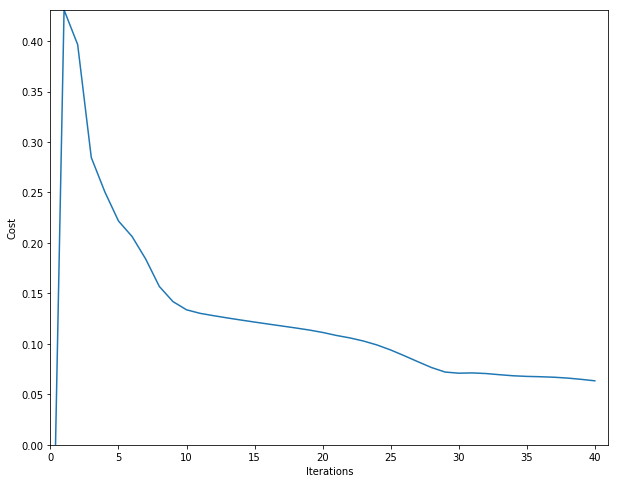

F-Score: 0.954
Accuracy:  0.9544339159651176
             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98     24283
        1.0       0.77      0.64      0.70      2206

avg / total       0.95      0.95      0.95     26489

[[23871   412]
 [  795  1411]]


In [32]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations") 
plt.axis([0,len(cost_history),0,np.max(cost_history)])
plt.show()


p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Accuracy: ", accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

In [33]:
model_path_f = '../models/RNN/'
filename = 'my_RNN_model_S27_100.meta'


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
loader = tf.train.import_meta_graph(model_path_f+filename)
loader.restore(sess, tf.train.latest_checkpoint(model_path_f))

SR = 44100
####
justone = True
while(justone):
    justone = False
    #print("start to record the audio.")
    '''
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    #print("Recording finished.")
    stream.stop_stream()
    stream.close()

    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    '''
    ####
    filename1 = '../data/phantom/JUNE_01_PHANTOMS/wavs/P1_up_and_down.wav'
    filename2 = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/canopy_heavy_wind.wav'
    
    sample, sample_rate = librosa.load(filename1,SR)
    print(sample.shape)
    
    
    freqs, times, spectrogram = log_specgram(sample, sample_rate)    

    spectrogram = (spectrogram - mean) / std
    
    dataX = spectrogram
    #print(dataX.shape)
    #print('delta shape:',dataX.shape)

    X_hot_list= []
    #print(dataX.shape[0] - seq_length+1)
    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        X_hot_list.append(_x)
    X_hot = np.array(X_hot_list[:])
    #print(X_hot[0])
    #print('\n\n\n')
    y_pred = sess.run(Y_pred,feed_dict={X: X_hot})
    #y_pred[y_pred<0.5] = 0
    #y_pred[y_pred>=0.5] = 1
    print(y_pred[20:30] )
    y_true = np.ones(shape=[y_pred.shape[0]])
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>=0.5] = 1
    
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score:", round(f,3))
    print("Accuracy: ", accuracy_score(y_true, y_pred))

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    '''
    if y_pred[0] == 1:
        print('The sound is Drone')
    else :
        print('THe sound isn\'t Drone')
    '''

sess.close()

INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S9_40
(884736,)
[[0.5819471 ]
 [0.581947  ]
 [0.58194697]
 [0.581947  ]
 [0.581947  ]
 [0.581947  ]
 [0.5819471 ]
 [0.58194697]
 [0.581947  ]
 [0.581947  ]]
F-Score: 0.904
Accuracy:  0.9043565348022033
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.90      0.95      1997

avg / total       1.00      0.90      0.95      1997

[[   0    0]
 [ 191 1806]]


c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

